# Directed Edge-Local Triangle ERGM
The statistics for this directed, spatial ERGM are the usual edge density and the local 3-cycle density
$$t(G) = \frac{\textrm{# of local 3-cycles in G}}{\textrm{# number of local 3-cycles if G were complete}},$$
where a local 3-cycle is a 3-cycle on three nodes $\{i, j, k\}$ in $G$ such that $d(i, j), d(j, k), d(k, i) < r$ for some fixed radius $r$. To be precise, given a directed graph $G$ with no self-loops and adjacency matrix $A$,
$$t(G) = \frac{\operatorname{tr} (M(r) \circ A)^3 / 3}{\operatorname{tr} A^3 / 3},$$
where $\circ$ denotes the element-wise product and $M(r)_{ij} = 1$ if and only if $i \neq j$ and $d(i, j) < r$.

In [1]:
import Pkg
Pkg.activate("..")

  Activating project at `~/research/xaqlab/ergm.jl`


## Define ERGM

In [2]:
using ergm.stats
using LinearAlgebra

n = 50
node_locations = rand(3, 50)
node_metric = [
    norm(node_locations[i] - node_locations[j])
    for i ∈ 1:n, j ∈ 1:n
]
local_radius = 0.2
local_mask = node_metric .< local_radius

max_edge_count = n * (n - 1)
max_local_triangle_count = sum(local_mask ^ 2 .* local_mask') / 3

sufficient_statistics = DeltaStats(
    function(G)
        n = G.n
        A = G.adjacency
        
        edge_count = sum(A)
        edge_density = edge_count / max_edge_count
        
        local_A = local_mask .* A
        local_triangle_count = sum(local_A ^ 2 .* local_A') / 3
        local_triangle_density = local_triangle_count / max_local_triangle_count
        
        [edge_density, local_triangle_density]
    end,
    function(G, current_statistics, update)
        n = G.n
        A = G.adjacency
        ix, x = update
        i, j = ix
        
        delta_edge_count = x - G[ix]
        delta_edge_density = delta_edge_count / max_edge_count
        
        local_A = local_mask .* A
        delta_local_triangle_count = (x - G[ix]) * local_mask[i, j] * sum(local_A[j, :] .* local_A[:, i])
        delta_local_triangle_density = delta_local_triangle_count / max_local_triangle_count
        
        current_statistics .+ [delta_edge_density, delta_local_triangle_density]
    end
)

DeltaStats(var"#3#5"(), var"#4#6"(), UndefInitializer(), UndefInitializer())

In [3]:
# percentage of total possible edges which are considered "local"
(sum(local_mask) - n) / (n * (n - 1)) * 100

36.97959183673469

In [4]:
# percentage of total possible 3-cycles which are considered "local"
(sum(local_mask ^ 2 .* local_mask') / 3) / (n * (n - 1) * (n - 2) / 3) * 100

14.639455782312927

## Define Ground-Truth Natural Parameters

In [5]:
using ergm.models
using ergm.sampler
using ergm.spaces
using Statistics

θ_gt = [-1e3, 2e3]
model = ExponentialFamily(sufficient_statistics, θ_gt)
sampler = ParallelGibbsSampler(
    DiGraph(zeros(Bool, n, n)), model, 3, 5, Threads.nthreads()
);

# Verify Ground-Truth is Far From Edros-Renyi

In [7]:
function expectation_ergm(θe, θt)
    m = 100
    update_sampler_params(sampler, [θe, θt])
    _, ss = sample(sampler, m)
    mean(ss, dims=2)
end

function expectation_er(p)
    m = 100
    ss = hcat([get_stats(sufficient_statistics, DiGraph(rand(n, n) .< p)) for i ∈ 1:m]...)
    mean(ss, dims=2)
end

expectation_er (generic function with 1 method)

In [8]:
# ground-truth expectation parameters for ERGM
e_ergm = expectation_ergm(θ_gt...)

2×1 Matrix{Float64}:
 0.5967346938775574
 0.7698460734200739

In [9]:
# expectations for Erdos-Renyi with matching density
e_er = expectation_er(e_ergm[1])

2×1 Matrix{Float64}:
 0.5967306122448978
 0.17838986988847583

In [10]:
# what factor are directed 3-cycles over-represented by relative to Erdos-Renyi?
e_ergm[2] / e_er[2]

4.315525729691711

# Attempt to Recover Ground-Truth Parameters

In [17]:
using ergm.optim
using ergm.inference

update_params(model, θ_gt)
update_sampler_params(sampler, θ_gt)
Gs, _ = sample(sampler, 100)
update_params(model, [0.0, 0.0])
optimizer = SGD(10e2, [0.0, 0.0], 100, 0.0, "log.txt")
θs, Ls, target_Es, Es = mcmc_mle(Gs, model, optimizer, 1000, 5, 3);

## Results for Recovering Expectation Parameters

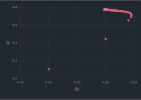

In [18]:
using Gadfly
using DataFrames

Gadfly.push_theme(:dark)
Es_mat = hcat(Es...)
df = DataFrame(:Ee => Es_mat[1, :], :Et => Es_mat[2, :])
plot(
    layer(df, x=:Ee, y=:Et, Geom.point),
    layer(x=[target_Es[1]], y=[target_Es[2]], Geom.point, color=[colorant"blue"])
)

## Results for Recovering Natural Parameters

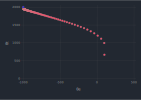

In [20]:
df = DataFrame(:θe => θs[1, :], :θt => θs[2, :])
plot(
    layer(df, x=:θe, y=:θt, Geom.point),
    layer(x=[θ_gt[1]], y=[θ_gt[2]], color=[colorant"blue"])
)